<a href="https://colab.research.google.com/github/BintaBall/plants_prediction/blob/main/plants_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# NE PAS EXECUTER CE CODE
import shutil
import os

# Supprimer le dossier PlantVillage s'il existe
if os.path.exists("plantvillage"):
    shutil.rmtree("plantvillage")
    print("Le dossier supprimé avec succès.")

# Supprimer l'archive zip si elle est présente
if os.path.exists("plantdisease.zip"):
    os.remove("plantdisease.zip")
    print("Le ichier 'plantdisease.zip' supprimé avec succès.")


In [2]:
#NE PAS EXECUTER CE CODE
#LE DOSSIER A DEJA ETE CREE
!pip install -q kaggle

from google.colab import files
files.upload()
#Ici on doit ajouter un Token API Kaggle, j'ai donné le mien

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Télécharger le dataset PlantVillage depuis Kaggle
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip
# On a deux dossiers qui se chargent, PlantVillage en majuscule et celui en muniscule
#On va utiliser celui en majuscule pour notre training

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import joblib

# Dossier contenant les images
data_dir = 'PlantVillage'

# Créer un dossier pour sauvegarder les résultats
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Récupération automatique des catégories (noms des sous-dossiers)
categories = sorted([
   d for d in os.listdir(data_dir)
   if os.path.isdir(os.path.join(data_dir, d))
])
print("Catégories :", categories)

# Mapping des labels
labels = {category: idx for idx, category in enumerate(categories)}


Catégories : ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [5]:
import os
import shutil
import random

# Dossiers source et destination
source_dir = 'PlantVillage'
test_dir = 'PlantVillage_test'
test_ratio = 0.2  # 20% des images par classe

# Création du dossier test
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        n_test = max(1, int(len(images) * test_ratio))  # au moins une image

        selected = random.sample(images, n_test)
        dest_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        for img in selected:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(dest_class_dir, img)
            shutil.copy2(src_path, dst_path)

        print(f"{len(selected)} images copiées pour la classe {class_name}")

print("Création du dossier test terminée.")


381 images copiées pour la classe Tomato_Late_blight
200 images copiées pour la classe Potato___Late_blight
280 images copiées pour la classe Tomato__Target_Spot
74 images copiées pour la classe Tomato__Tomato_mosaic_virus
30 images copiées pour la classe Potato___healthy
199 images copiées pour la classe Pepper__bell___Bacterial_spot
318 images copiées pour la classe Tomato_healthy
354 images copiées pour la classe Tomato_Septoria_leaf_spot
641 images copiées pour la classe Tomato__Tomato_YellowLeaf__Curl_Virus
335 images copiées pour la classe Tomato_Spider_mites_Two_spotted_spider_mite
295 images copiées pour la classe Pepper__bell___healthy
190 images copiées pour la classe Tomato_Leaf_Mold
425 images copiées pour la classe Tomato_Bacterial_spot
200 images copiées pour la classe Potato___Early_blight
200 images copiées pour la classe Tomato_Early_blight
Création du dossier test terminée.


In [8]:
from google.colab import files
import shutil
import os

# Nom du dossier à zipper
folder_to_zip = "PlantVillage_test"

# Vérification que le dossier existe
if os.path.exists(folder_to_zip):
    # Création de l'archive ZIP
    zip_filename = shutil.make_archive("PlantVillage_test", 'zip', folder_to_zip)

    # Téléchargement du fichier ZIP
    files.download(zip_filename)
else:
    print("dossier introuvable")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X = []
y = []

# Chargement et traitement des images
for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path).convert('L').resize((64, 64))
            img_array = np.array(img).flatten()
            X.append(img_array)
            y.append(labels[category])
        except Exception as e:
            print(f"Erreur avec {img_name} : {e}")
            continue

X = np.array(X) / 255.0
y = np.array(y)

print(f"Nombre d'images : {len(X)}")
print(f"Nombre de classes : {len(categories)}")

Erreur avec svn-r6Yb5c : cannot identify image file 'PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Nombre d'images : 20638
Nombre de classes : 15


<ipython-input-16-13a80a6d4b4f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts.values, palette='viridis')


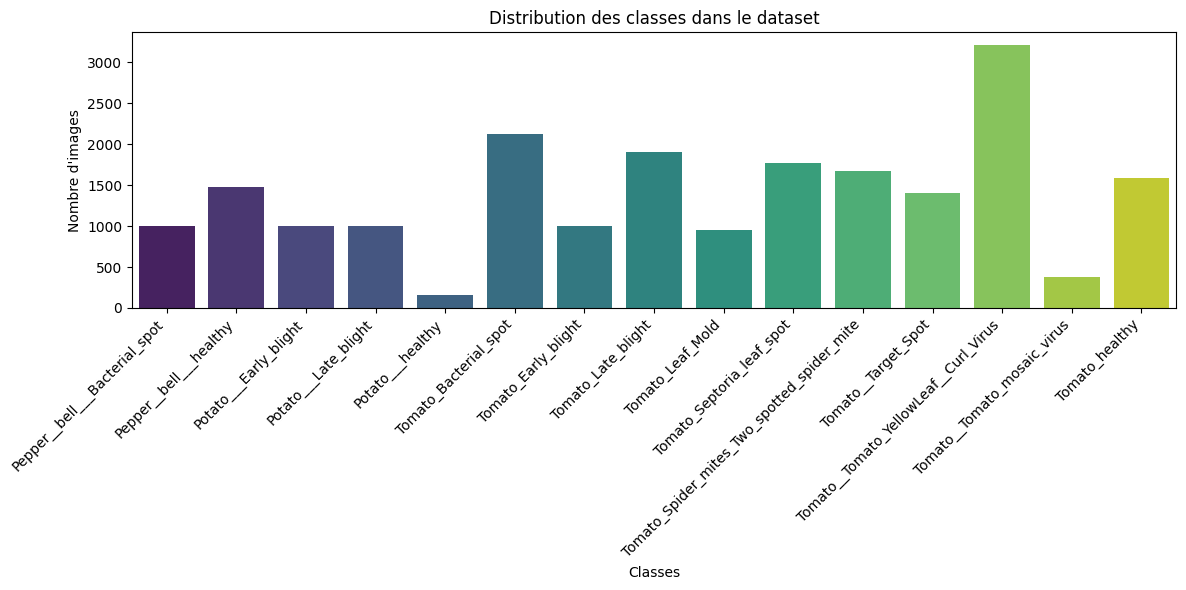

Distribution des classes sauvegardée : results/class_distribution.png


In [ ]:
import pandas as pd
# Distribution des classes
class_counts = pd.Series(y).value_counts().sort_index()
class_names = [cat for cat, idx in sorted(labels.items(), key=lambda x: x[1])]

plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_counts.values, palette='viridis')
plt.title("Distribution des classes dans le dataset")
plt.ylabel("Nombre d'images")
plt.xlabel("Classes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Sauvegarde du graphique
dist_path = os.path.join(results_dir, 'class_distribution.png')
plt.savefig(dist_path)
plt.show()

print(f"Distribution des classes sauvegardée : {dist_path}")

In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from PIL import UnidentifiedImageError

# Dossier de base
data_dir = 'PlantVillage'
output_dir = 'PlantVillage_augmented'

# Paramètres
target_size = (64, 64)
augmentations_per_image = 5

# Créer le nouveau dossier de sortie
os.makedirs(output_dir, exist_ok=True)

# Définir la data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Analyser la distribution actuelle
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])

# Trouver la classe avec le plus grand nombre d'images
max_count = max(class_counts.values())

# Appliquer l'augmentation
for class_name, count in class_counts.items():
    print(f"\nAugmentation de la classe {class_name}")
    class_input_dir = os.path.join(data_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    os.makedirs(class_output_dir, exist_ok=True)

    # Copier les images existantes
    for img_name in os.listdir(class_input_dir):
        src_path = os.path.join(class_input_dir, img_name)
        dst_path = os.path.join(class_output_dir, img_name)

        try:
            img = load_img(src_path, target_size=target_size)
            save_img(dst_path, img)
        except (UnidentifiedImageError, OSError) as e:
            print(f"Image ignorée (non valide) : {src_path}")

    # Générer des images supplémentaires si besoin
    images = [img for img in os.listdir(class_input_dir)]

    existing_count = len(os.listdir(class_output_dir))
    images_needed = max_count - existing_count

    if images_needed <= 0:
        continue  # Pas besoin d'augmenter cette classe

    generated = 0
    while generated < images_needed:
        img_name = random.choice(images)
        img_path = os.path.join(class_input_dir, img_name)

        try:
            img = load_img(img_path, target_size=target_size)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1):
                new_img_name = f"aug_{generated}_{img_name}"
                save_img(os.path.join(class_output_dir, new_img_name), batch[0])
                generated += 1
                if generated >= images_needed:
                    break
        except (UnidentifiedImageError, OSError) as e:
            print(f"Image ignorée pendant l'augmentation : {img_path}")

print("Augmentation terminée.")



Augmentation de la classe Tomato_Early_blight

Augmentation de la classe Tomato__Tomato_YellowLeaf__Curl_Virus
Image ignorée (non valide) : PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c

Augmentation de la classe Tomato_Late_blight

Augmentation de la classe Potato___Late_blight

Augmentation de la classe Pepper__bell___healthy

Augmentation de la classe Tomato_Leaf_Mold

Augmentation de la classe Pepper__bell___Bacterial_spot

Augmentation de la classe Tomato_healthy

Augmentation de la classe Tomato__Target_Spot

Augmentation de la classe Tomato_Spider_mites_Two_spotted_spider_mite

Augmentation de la classe Tomato_Bacterial_spot

Augmentation de la classe Potato___Early_blight

Augmentation de la classe Tomato_Septoria_leaf_spot

Augmentation de la classe Potato___healthy

Augmentation de la classe Tomato__Tomato_mosaic_virus
Augmentation terminée.


In [ ]:
import os
import numpy as np
from PIL import Image

# Dossier du nouveau dataset augmenté
output_dir = 'PlantVillage_augmented'

# Récupération automatique des catégories (noms des sous-dossiers)
categories_augmented = sorted([
    d for d in os.listdir(output_dir)
    if os.path.isdir(os.path.join(output_dir, d))  # ici c'était une petite erreur
])
print("Catégories :", categories_augmented)

# Mapping des labels (nom -> index)
labels = {category: idx for idx, category in enumerate(categories_augmented)}

# Listes pour les données
X = []
y = []

# Chargement et traitement des images
for category in categories_augmented:
    path = os.path.join(output_dir, category)
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path).convert('L').resize((64, 64))  # gris et 64x64
            img_array = np.array(img).flatten()
            X.append(img_array)
            y.append(labels[category])
        except Exception as e:
            print(f"Erreur avec {img_name} : {e}")
            continue

# Conversion en numpy array
X = np.array(X) / 255.0  # Normalisation entre 0 et 1
y = np.array(y)

print(f"Nombre d'images chargées : {X.shape[0]}")
print(f"Taille d'une image : {X.shape[1]}")
print(f"Nombre de classes : {len(np.unique(y))}")


Catégories : ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Nombre d'images chargées : 48135
Taille d'une image : 4096
Nombre de classes : 15


<ipython-input-19-e68ecd3793ea>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts.values, palette='viridis')


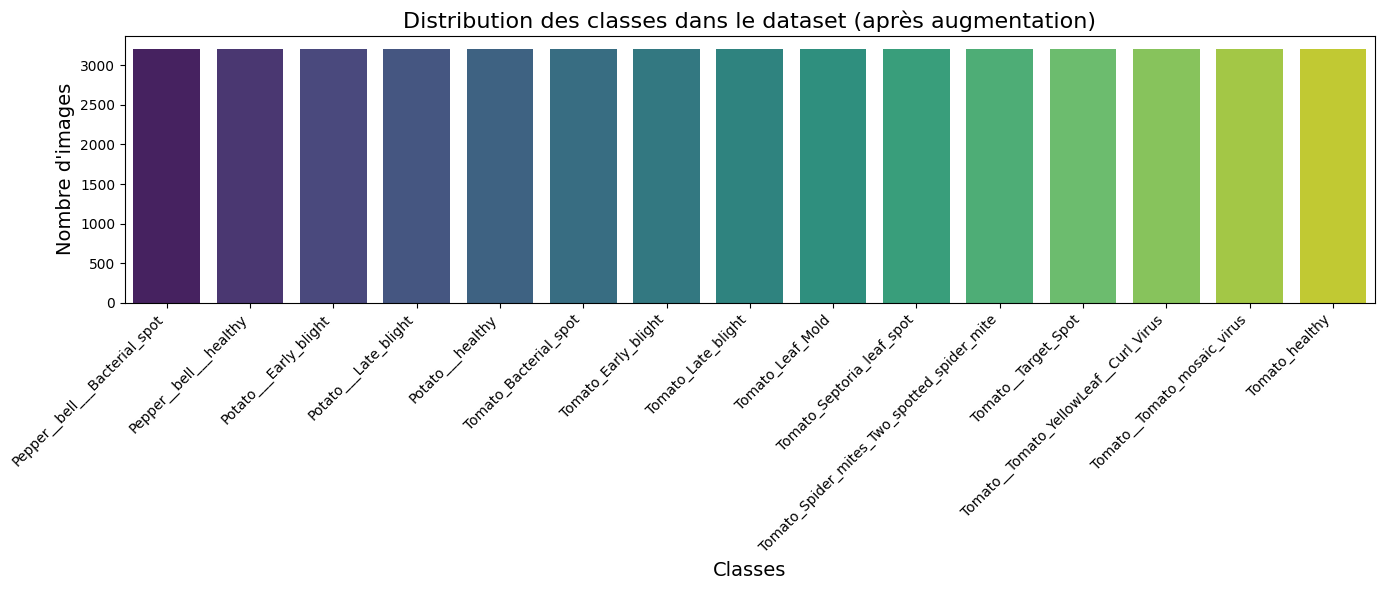

Distribution des classes sauvegardée sous : results/class_distribution_augmented.png


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assure-toi que le dossier results_dir existe
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Distribution des classes
class_counts = pd.Series(y).value_counts().sort_index()
class_names = [cat for cat, idx in sorted(labels.items(), key=lambda x: x[1])]

plt.figure(figsize=(14, 6))
sns.barplot(x=class_names, y=class_counts.values, palette='viridis')
plt.title("Distribution des classes dans le dataset (après augmentation)", fontsize=16)
plt.ylabel("Nombre d'images", fontsize=14)
plt.xlabel("Classes", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Sauvegarde du graphique
dist_path = os.path.join(results_dir, 'class_distribution_augmented.png')
plt.savefig(dist_path)
plt.show()

print(f"Distribution des classes sauvegardée sous : {dist_path}")


In [ ]:
# Séparation en jeu d'entraînement et de test
if len(X) > 0 and len(y) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=42)
else:
    raise ValueError("Pas de données disponibles.")

# Modèles à entraîner
classifiers = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    SVC(kernel='rbf', gamma='scale', probability=True),
    DecisionTreeClassifier(random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

model_names = ['random_forest', 'svm_rbf', 'decision_tree', 'knn']
accuracies = {}
conf_matrices = {}

# Entraînement et évaluation
for clf, name in zip(classifiers, model_names):
    print(f"\n Entraînement du modèle : {name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=categories_augmented, output_dict=False)

    accuracies[name] = acc
    conf_matrices[name] = cm

    # Sauvegarde du modèle
    model_path = os.path.join(results_dir, f'{name}.pkl')
    joblib.dump(clf, model_path)
    print(f" Modèle sauvegardé : {model_path}")
    print(f" {name} Accuracy: {acc:.2f}")

    # Sauvegarder le rapport dans un fichier texte
    report_path = os.path.join(results_dir, f'{name}_report.txt')
    with open(report_path, 'w') as f:
        f.write(classification_report(y_test, y_pred, target_names=categories_augmented))
    print(f"Rapport de classification sauvegardé : {report_path}")



 Entraînement du modèle : random_forest
 Modèle sauvegardé : results/random_forest.pkl
 random_forest Accuracy: 0.75
Rapport de classification sauvegardé : results/random_forest_report.txt

 Entraînement du modèle : svm_rbf


In [ ]:
# Code necessairepour voir la précision des models
# Bar plot des précisions
plt.figure(figsize=(10, 6))  # un peu plus grand pour plus de lisibilité
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'orange', 'green', 'purple'])
plt.title('Accuracy des modèles sur Dataset Augmenté')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Afficher la précision au-dessus de chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Sauvegarde du graphique
accuracy_path = os.path.join(results_dir, 'accuracy_plot.png')
plt.savefig(accuracy_path)
plt.show()
print(f"Graphique accuracy sauvegardé ici : {accuracy_path}")

In [ ]:
# Matrices de confusion
for name, cm in conf_matrices.items():
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',  # annot=True pour afficher les nombres
                xticklabels=categories, yticklabels=categories)
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Chemin de sauvegarde
    path = os.path.join(results_dir, f'confusion_matrix_{name}.png')
    plt.savefig(path)
    plt.show()
    print(f"Matrice de confusion sauvegardée : {path}")

print("Tous les modèles ont été entraînés et les résultats sont enregistrés.")

In [ ]:
# Calcul des F1-scores pondérés
f1_scores = {}

for name, clf in zip(model_names, classifiers):
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_scores[name] = report['weighted avg']['f1-score']

# Graphique F1-scores
plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['skyblue', 'orange', 'green', 'purple'])
plt.title('F1-score pondéré des modèles')
plt.ylabel('F1-score')
plt.ylim(0, 1)

# Ajouter les valeurs sur les barres
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()

# Sauvegarde
f1_path = os.path.join(results_dir, 'f1_scores_plot.png')
plt.savefig(f1_path)
plt.show()
print(f"Graphique F1-score sauvegardé : {f1_path}")